In [2]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
import pandas as pd
import polars as pl
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from src.helpers import preprocessing as preproc
from src.helpers.postprocessing import get_top_k_representative_docs, from_list_to_string, safe_json_load
from src.helpers.sentiment_analysis import SentimentModel
from src.topol_modeling import TopolModeling as TOPOL
from sknetwork.clustering import Leiden
from scipy.sparse import csr_matrix
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.openai_api import chat_completion as openai_chat_completion
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding
from src.google_ai_api import chat_completion as google_chat_completion

In [3]:
DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.getenv("OUTPUTS_PATH")

DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

---

# Getting data

In [4]:
df = pd.read_pickle(os.path.join(DATA_PATH, "us_fed_speeches.pickle"))
FILES_PREFIX = "us_speeches"

In [5]:
# breakpoint = pd.to_datetime("2007-05-01")

# df["label"] = 1.0
# df.loc[df["date"] <= breakpoint, "label"] = 0

In [6]:
print(len(df[df["label"] == 0]), len(df[df["label"] == 1]))
df

333 267


,date,text,label
0,2004-01-03,Ben S Bernanke: Fedspeak\nSpeech by Mr Ben S B...,0.0
1,2004-01-03,Ben S Bernanke: Conducting monetary policy at ...,0.0
2,2004-01-03,Alan Greenspan: Risk and uncertainty in moneta...,0.0
3,2004-01-04,Ben S Bernanke: Monetary policy and the econom...,0.0
4,2004-01-04,"Roger W Ferguson, Jr: Lessons from past produc...",0.0
...,...,...,...
595,2010-03-25,Ben S Bernanke: Federal Reserve's exit strateg...,1.0
596,2010-03-26,Daniel K Tarullo: Lessons from the crisis stre...,1.0
597,2010-03-26,Kevin Warsh: An ode to independence\nSpeech by...,1.0
598,2010-03-26,Brian P Sack: Dollar asset markets - prospects...,1.0


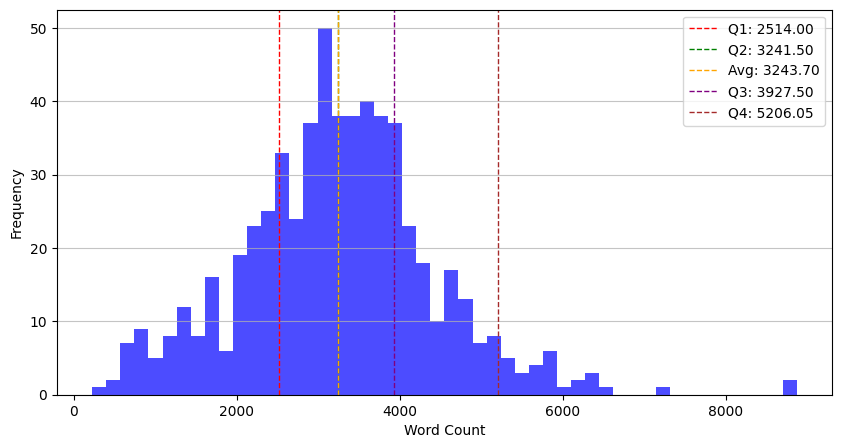

In [7]:
word_counts = df["text"].apply(lambda x: len(x.split()))
q1_word_counts = word_counts.quantile(0.25)
q2_word_counts = word_counts.quantile(0.50)
avg_word_counts = word_counts.mean()
q3_word_counts = word_counts.quantile(0.75)
q4_word_counts = word_counts.quantile(0.95)
plt.figure(figsize=(10, 5))
plt.hist(word_counts, bins=50, color='blue', alpha=0.7)
plt.axvline(q1_word_counts, color='red', linestyle='dashed', linewidth=1, label=f'Q1: {q1_word_counts:.2f}')
plt.axvline(q2_word_counts, color='green', linestyle='dashed', linewidth=1, label=f'Q2: {q2_word_counts:.2f}')
plt.axvline(avg_word_counts, color='orange', linestyle='dashed', linewidth=1, label=f'Avg: {avg_word_counts:.2f}')
plt.axvline(q3_word_counts, color='purple', linestyle='dashed', linewidth=1, label=f'Q3: {q3_word_counts:.2f}')
plt.axvline(q4_word_counts, color='brown', linestyle='dashed', linewidth=1, label=f'Q4: {q4_word_counts:.2f}')
plt.legend()
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

---

# Pre-processing data

##### 1. Data cleaning

In [8]:
entities_to_mask = ["DATE", "TIME", "ORGANIZATION", "NUM", "LOCATION"]
STOP_WORDS += entities_to_mask

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_texts.pickle")
if os.path.exists(fpath):
    print(f"Loading cleaned texts from {fpath}")
    with open(fpath, "rb") as f:
        texts = pickle.load(f)
    print(f"Loaded {len(texts)} texts")
else:
    print(f"Generating cleaned texts for {len(df)} raw texts...")
    texts = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        cleaned_text = preproc.get_clean_text(row, entities_to_mask=entities_to_mask, max_lenght=5000)
        texts.append(cleaned_text)
    with open(fpath, "wb") as f:
        pickle.dump(texts, f)
    print(f"Saved {len(texts)} cleaned texts to {fpath}.")

df["text"] = texts
del fpath

Loading cleaned texts from /Users/tig1/Programming/TOPOL/data/us_speeches_texts.pickle
Loaded 600 texts


##### 2. Embedding texts

In [9]:
EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_embeddings.pickle")
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} text...")
    embeddings = EMBEDDING_MODEL.encode(df["text"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()
del fpath

Loading embeddings from /Users/tig1/Programming/TOPOL/data/us_speeches_embeddings.pickle
Loaded 600 embeddings


##### 3.a. Sentiment Analysis: FinBERT

In [10]:
sentiment_model = SentimentModel(model_name="ProsusAI/finbert", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_finbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_finbert"] = sentiments
df["sentiment_score_finbert"] = df["sentiment_finbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/us_speeches_sentiments_finbert.pickle
Loaded 600 sentiments


##### 3.b. Sentiment Analysis: Multilingual DistilBERT

In [11]:
sentiment_model = SentimentModel(model_name="tabularisai/multilingual-sentiment-analysis", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_distilbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_distilbert"] = sentiments
df["sentiment_score_distilbert"] = df["sentiment_distilbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/us_speeches_sentiments_distilbert.pickle
Loaded 600 sentiments


---

# Preliminary analysis

### Sentiment analysis

In [12]:
contextual_boundary_0 = df[df["label"] == 0].copy() # Prior breakpoint
contextual_boundary_1 = df[df["label"] == 1].copy() # After breakpoint

##### FinBERT model

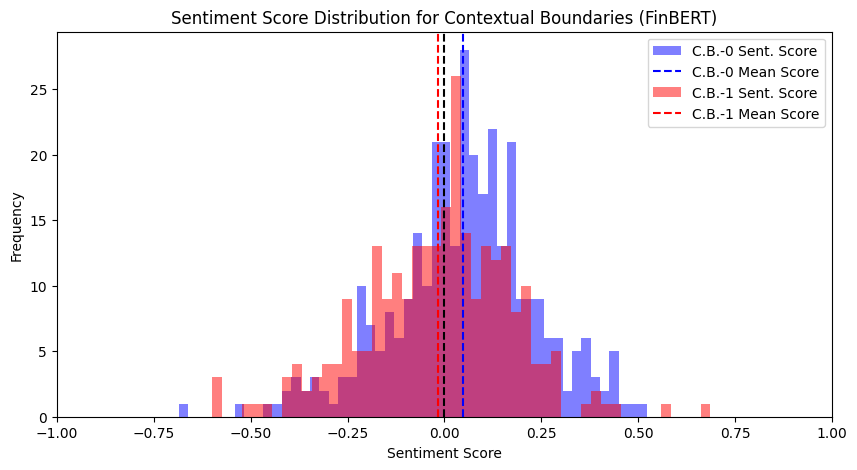

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(contextual_boundary_0["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='C.B.-0 Sent. Score', color='blue')
plt.axvline(x=contextual_boundary_0["sentiment_score_finbert"].mean(), color='blue', linestyle='--', label='C.B.-0 Mean Score')
plt.hist(contextual_boundary_1["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='C.B.-1 Sent. Score', color='red')
plt.axvline(x=contextual_boundary_1["sentiment_score_finbert"].mean(), color='red', linestyle='--', label='C.B.-1 Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Contextual Boundaries (FinBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_finbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

##### DistilBERT model

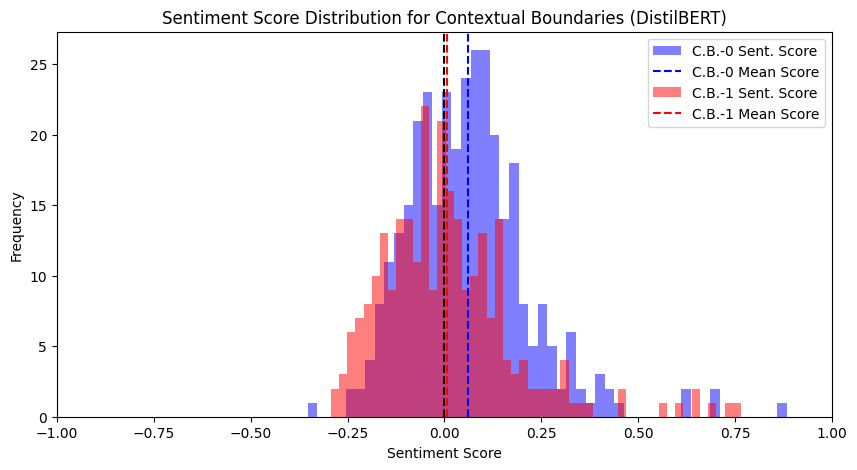

In [14]:
plt.figure(figsize=(10, 5))
plt.hist(contextual_boundary_0["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='C.B.-0 Sent. Score', color='blue')
plt.axvline(x=contextual_boundary_0["sentiment_score_distilbert"].mean(), color='blue', linestyle='--', label='C.B.-0 Mean Score')
plt.hist(contextual_boundary_1["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='C.B.-1 Sent. Score', color='red')
plt.axvline(x=contextual_boundary_1["sentiment_score_distilbert"].mean(), color='red', linestyle='--', label='C.B.-1 Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Contextual Boundaries (DistilBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_distilbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# TOPol Modeling

### Create TOPol model object

In [15]:
umap_params = {
    'n_neighbors': 100,
    'min_dist': 0.0,
    'metric': 'cosine', # do not change this
}

leiden_params = {
    'resolution': 1.5,
    'modularity': 'dugue', # do not change this
}

topol_model = TOPOL(
    n_components=50,
    umap_model_params=umap_params,
    leiden_model_params=leiden_params,
    random_state=RANDOM_STATE,
)

### Fit TOPol model

In [16]:
df = pl.from_pandas(df)
topol_model.fit(df)

UMAP applied successfully.
Leiden clustering applied successfully.


### Default setup analysis

In [17]:
cb0_cluster_info, cb1_cluster_info = topol_model.get_cluster_info(label_col="label")

In [18]:
cb0_cluster_info

cluster,size,avg_prob,centroid,reduced_centroid,2D_centroid,cosine_dispersion,l2_dispersion,dot_product_dispersion
i32,i32,f64,"array[f64, 1536]","array[f64, 50]","array[f64, 2]",f64,f64,f64
0,53,0.695196,"[-0.003278, 0.001114, … -0.012937]","[1.88601, 1.937971, … 6.501184]","[0.41082, 6.171975]",0.173744,0.557366,0.3173
1,63,0.765139,"[0.009838, 0.019493, … -0.011851]","[1.719889, 1.81425, … 6.264787]","[-1.261685, 7.051733]",0.146609,0.509861,0.271725
2,26,0.577826,"[0.006046, 0.020238, … -0.002873]","[1.230845, 1.547857, … 6.222399]","[2.388209, 9.478988]",0.138554,0.500284,0.257911
3,48,0.794425,"[0.021526, 0.026192, … 0.000248]","[0.875302, 1.514818, … 6.093483]","[4.106255, 9.365142]",0.15333,0.526036,0.28315
4,2,0.491366,"[-0.023507, 0.02464, … 0.007646]","[1.340412, 1.889397, … 6.392251]","[1.496208, 7.865804]",0.072776,0.374508,0.140256
…,…,…,…,…,…,…,…,…
6,42,0.688654,"[0.018128, 0.015915, … -0.006447]","[1.940555, 1.654094, … 6.367298]","[-1.6319, 5.297872]",0.173777,0.556936,0.317355
7,16,0.627282,"[0.033481, 0.014835, … -0.009079]","[1.069062, 1.570592, … 6.056847]","[0.569662, 9.122775]",0.180895,0.568385,0.329068
8,35,0.562838,"[0.015776, 0.01634, … -0.009356]","[1.856317, 1.702956, … 6.376786]","[-0.840433, 5.92326]",0.199958,0.595911,0.359933


In [19]:
cb0_cluster_info

cluster,size,avg_prob,centroid,reduced_centroid,2D_centroid,cosine_dispersion,l2_dispersion,dot_product_dispersion
i32,i32,f64,"array[f64, 1536]","array[f64, 50]","array[f64, 2]",f64,f64,f64
0,53,0.695196,"[-0.003278, 0.001114, … -0.012937]","[1.88601, 1.937971, … 6.501184]","[0.41082, 6.171975]",0.173744,0.557366,0.3173
1,63,0.765139,"[0.009838, 0.019493, … -0.011851]","[1.719889, 1.81425, … 6.264787]","[-1.261685, 7.051733]",0.146609,0.509861,0.271725
2,26,0.577826,"[0.006046, 0.020238, … -0.002873]","[1.230845, 1.547857, … 6.222399]","[2.388209, 9.478988]",0.138554,0.500284,0.257911
3,48,0.794425,"[0.021526, 0.026192, … 0.000248]","[0.875302, 1.514818, … 6.093483]","[4.106255, 9.365142]",0.15333,0.526036,0.28315
4,2,0.491366,"[-0.023507, 0.02464, … 0.007646]","[1.340412, 1.889397, … 6.392251]","[1.496208, 7.865804]",0.072776,0.374508,0.140256
…,…,…,…,…,…,…,…,…
6,42,0.688654,"[0.018128, 0.015915, … -0.006447]","[1.940555, 1.654094, … 6.367298]","[-1.6319, 5.297872]",0.173777,0.556936,0.317355
7,16,0.627282,"[0.033481, 0.014835, … -0.009079]","[1.069062, 1.570592, … 6.056847]","[0.569662, 9.122775]",0.180895,0.568385,0.329068
8,35,0.562838,"[0.015776, 0.01634, … -0.009356]","[1.856317, 1.702956, … 6.376786]","[-0.840433, 5.92326]",0.199958,0.595911,0.359933


Drift computed successfully, ready to visualize.


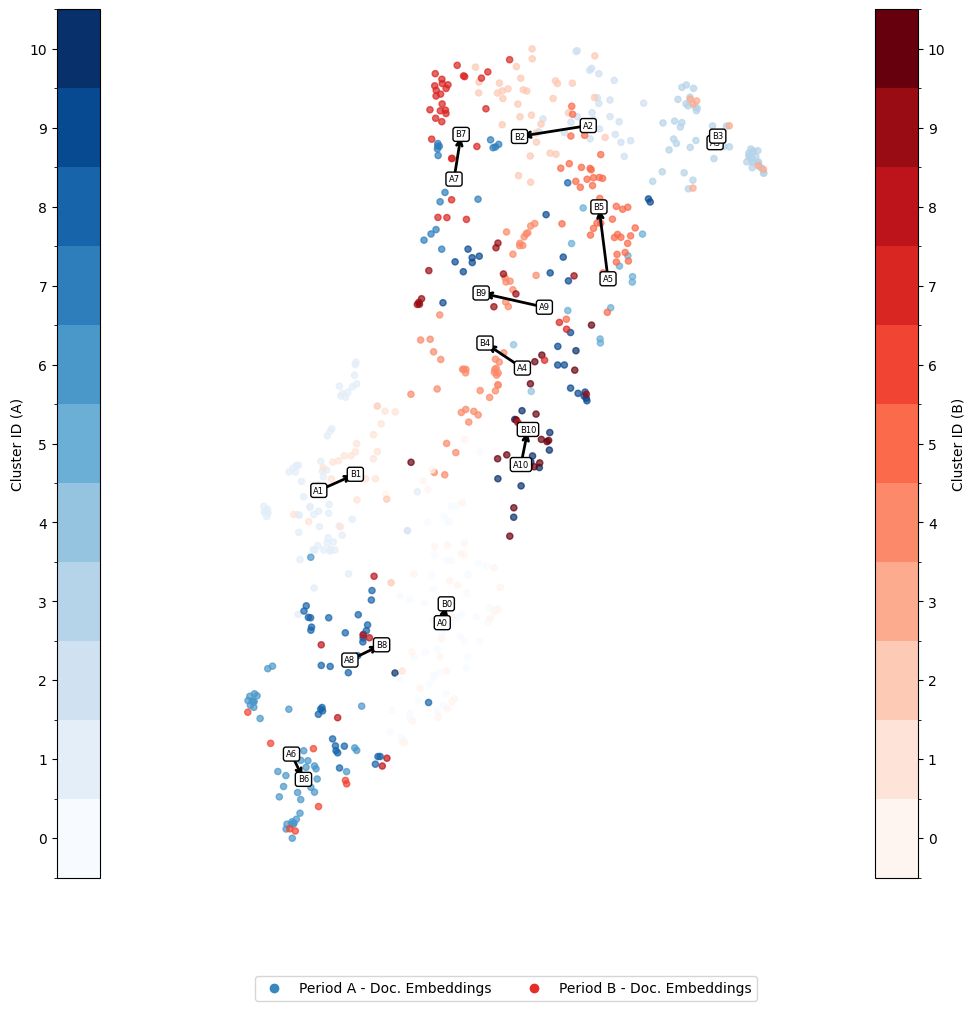

In [20]:
fig, ax = topol_model.visualize(label_col="label")
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_default_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Randomized contextual boundary analysis

In [21]:
random_cb0_cluster_info, random_cb1_cluster_info = topol_model.get_cluster_info(label_col="random_label")

In [22]:
random_cb0_cluster_info

cluster,size,avg_prob,centroid,reduced_centroid,2D_centroid,cosine_dispersion,l2_dispersion,dot_product_dispersion
i32,i32,f64,"array[f64, 1536]","array[f64, 50]","array[f64, 2]",f64,f64,f64
0,53,0.683232,"[-0.008667, 0.003989, … -0.013293]","[1.868831, 1.940299, … 6.497488]","[0.413397, 6.216668]",0.170403,0.552974,0.311769
1,48,0.746086,"[0.007768, 0.018167, … -0.011499]","[1.703111, 1.839056, … 6.284511]","[-1.145001, 7.015736]",0.131075,0.480593,0.244969
2,32,0.551105,"[0.005654, 0.02286, … -0.009025]","[1.227653, 1.571051, … 6.218066]","[1.823105, 9.407274]",0.142924,0.512251,0.265421
3,25,0.826528,"[0.015584, 0.024967, … 0.000619]","[0.847941, 1.508233, … 6.088917]","[4.215139, 9.352228]",0.146616,0.511399,0.271736
4,27,0.556954,"[-0.006005, 0.006251, … -0.000893]","[1.256554, 1.83928, … 6.348126]","[1.052958, 8.078876]",0.132123,0.489505,0.24679
…,…,…,…,…,…,…,…,…
6,34,0.644203,"[0.014794, 0.018802, … -0.006546]","[1.944871, 1.656774, … 6.378318]","[-1.540433, 5.247463]",0.17725,0.558906,0.323082
7,27,0.635245,"[0.0239, 0.027151, … -0.014217]","[1.047905, 1.568283, … 6.069534]","[0.745717, 9.294074]",0.166097,0.547977,0.304605
8,27,0.531586,"[0.016462, 0.012145, … -0.00562]","[1.827572, 1.704125, … 6.365881]","[-0.740804, 6.062846]",0.220719,0.619753,0.392722


In [23]:
random_cb1_cluster_info

cluster,size,avg_prob,centroid,reduced_centroid,2D_centroid,cosine_dispersion,l2_dispersion,dot_product_dispersion
i32,i32,f64,"array[f64, 1536]","array[f64, 50]","array[f64, 2]",f64,f64,f64
0,33,0.673191,"[0.000195, -0.001118, … -0.010368]","[1.870668, 1.939949, … 6.497382]","[0.461214, 6.225554]",0.174557,0.558728,0.318645
1,36,0.732963,"[0.011668, 0.018825, … -0.012715]","[1.682563, 1.810074, … 6.258705]","[-1.128772, 7.162407]",0.135374,0.491812,0.252421
2,31,0.581713,"[0.003512, 0.021466, … -0.005185]","[1.209649, 1.546938, … 6.209362]","[1.860088, 9.466473]",0.158229,0.53366,0.291421
3,30,0.768613,"[0.02459, 0.028661, … 0.000485]","[0.896737, 1.516093, … 6.096402]","[4.023815, 9.386045]",0.158332,0.536635,0.291594
4,25,0.558051,"[-0.008307, 0.010724, … -0.001773]","[1.276575, 1.846611, … 6.353992]","[0.961172, 7.968426]",0.115257,0.459607,0.217229
…,…,…,…,…,…,…,…,…
6,16,0.730742,"[0.017277, 0.01056, … -0.007094]","[1.940331, 1.644999, … 6.35226]","[-1.745226, 5.320929]",0.1685,0.552953,0.308608
7,23,0.658912,"[0.026372, 0.025148, … -0.020976]","[1.057976, 1.548036, … 6.036971]","[0.505511, 9.361402]",0.181626,0.567904,0.330264
8,16,0.545383,"[0.013732, 0.013413, … -0.015508]","[1.905787, 1.730757, … 6.406297]","[-0.794215, 5.73853]",0.189979,0.58093,0.343865


Drift computed successfully, ready to visualize.


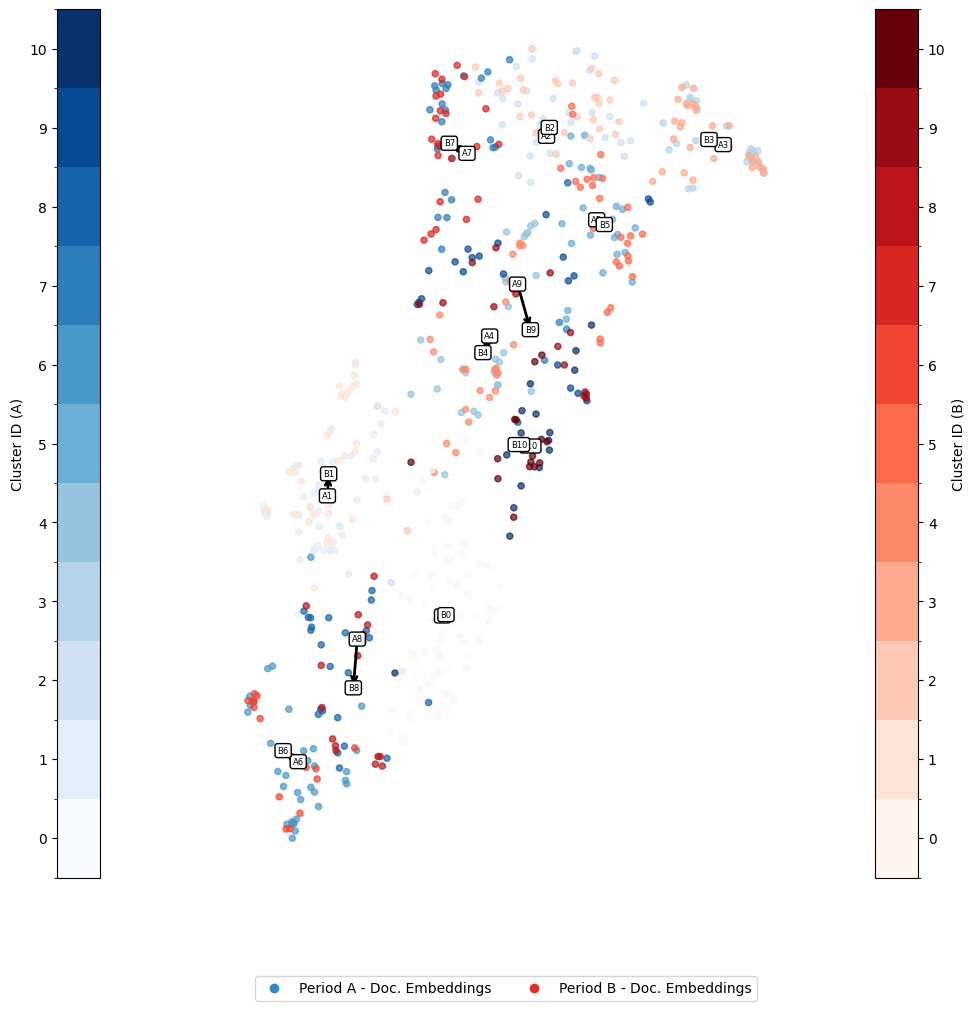

In [24]:
fig, ax = topol_model.visualize(label_col="random_label")
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_random_cb_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Drift analysis

In [25]:
assert cb0_cluster_info["cluster"].to_list() == cb1_cluster_info["cluster"].to_list(), "Cluster IDs are not the same for C.B.-0 and C.B.-1"
clusters = cb0_cluster_info["cluster"].to_list()

In [26]:
drifts_default = {}
for cluster_id, cb0_centroid, cb1_centroid in zip(clusters, cb0_cluster_info["centroid"].to_list(), cb1_cluster_info["centroid"].to_list()):
    drifts_default[cluster_id] = np.array(cb1_centroid) - np.array(cb0_centroid)

In [27]:
drifts_random_cb = {}
for cluster_id, cb0_centroid, cb1_centroid in zip(clusters, random_cb0_cluster_info["centroid"].to_list(), random_cb1_cluster_info["centroid"].to_list()):
    drifts_random_cb[cluster_id] = np.array(cb1_centroid) - np.array(cb0_centroid)

In [28]:
drift_similarities = {}
for cluster_id in clusters:
    drift_default = drifts_default[cluster_id]
    drift_random = drifts_random_cb[cluster_id]
    norm_ratio = np.linalg.norm(drift_default) / np.linalg.norm(drift_random)
    similarity = cosine_similarity([drift_default], [drift_random])[0][0]
    dot_prod = np.dot(drift_default, drift_random)
    drift_similarities[cluster_id] = {
        "cosine_similarity": similarity,
        "dot_product": dot_prod,
        "norm_ratio": norm_ratio
    }
pd.DataFrame(drift_similarities).T

,cosine_similarity,dot_product,norm_ratio
0,-0.214226,-0.003486,1.022756
1,-0.112763,-0.002656,2.089698
2,-0.193761,-0.007789,2.185995
3,-0.170384,-0.006018,1.705290
4,-0.110504,-0.006861,2.985370
5,-0.287765,-0.015965,2.296822
6,-0.557260,-0.030724,1.303168
7,-0.218238,-0.011153,2.083766
8,-0.064549,-0.003660,1.589197
9,-0.300355,-0.022158,1.484614


1.7882121173342809 0.5827560139114639


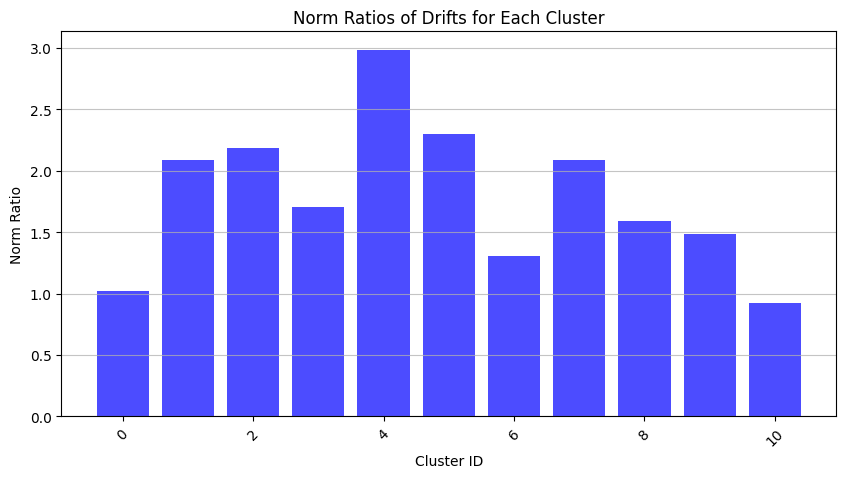

In [54]:
norm_ratios = [drift_similarities[cluster_id]["norm_ratio"] for cluster_id in clusters]
plt.figure(figsize=(10, 5))
plt.bar(clusters, norm_ratios, color='blue', alpha=0.7)
plt.xlabel('Cluster ID')
plt.ylabel('Norm Ratio')
plt.title('Norm Ratios of Drifts for Each Cluster')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_norm_ratios_HoTL_vs_random_CB.pdf"), format="pdf", bbox_inches='tight')
print(np.mean(norm_ratios), np.std(norm_ratios))
plt.show()

In [30]:
# Norm ratio entropy
norm_ratios = np.array(norm_ratios)
norm_ratios = norm_ratios / np.sum(norm_ratios)
norm_ratio_entropy = -np.sum(norm_ratios * np.log(norm_ratios + 1e-10)) / np.log(len(norm_ratios))  # Adding a small value to avoid log(0) and normalizing by log(len(norm_ratios))
print(f"Norm Ratio Entropy: {norm_ratio_entropy}")

Norm Ratio Entropy: 0.977746276464799


### Comparing with sentiment

In [60]:
cb0_df = topol_model.df.filter(pl.col("label") == 0)
sentiment_cb0_cluster_info = cb0_df.group_by("cluster")\
    .map_groups(lambda group: pl.DataFrame({
        "cluster": group["cluster"][0],
        "sentiment_score_finbert": np.mean(group["sentiment_score_finbert"].to_list(), axis=0),
        "sentiment_score_distilbert": np.mean(group["sentiment_score_distilbert"].to_list(), axis=0),
    }))
sentiment_cb0_cluster_info.mean()

cluster,sentiment_score_finbert,sentiment_score_distilbert
f64,f64,f64
5.0,0.075171,0.100529


In [61]:
cb1_df = topol_model.df.filter(pl.col("label") == 1)
sentiment_cb1_cluster_info = cb1_df.group_by("cluster")\
    .map_groups(lambda group: pl.DataFrame({
        "cluster": group["cluster"][0],
        "sentiment_score_finbert": np.mean(group["sentiment_score_finbert"].to_list(), axis=0),
        "sentiment_score_distilbert": np.mean(group["sentiment_score_distilbert"].to_list(), axis=0),
    }))
sentiment_cb1_cluster_info.mean()

cluster,sentiment_score_finbert,sentiment_score_distilbert
f64,f64,f64
5.0,-0.005925,0.042202


In [63]:
random_cb0_df = topol_model.df.filter(pl.col("random_label") == 0)
random_sentiment_cb0_cluster_info = random_cb0_df.group_by("cluster")\
    .map_groups(lambda group: pl.DataFrame({
        "cluster": group["cluster"][0],
        "sentiment_score_finbert": np.mean(group["sentiment_score_finbert"].to_list(), axis=0),
        "sentiment_score_distilbert": np.mean(group["sentiment_score_distilbert"].to_list(), axis=0),
    }))
random_sentiment_cb0_cluster_info.mean()

cluster,sentiment_score_finbert,sentiment_score_distilbert
f64,f64,f64
5.0,0.034068,0.042276


In [65]:
random_cb1_df = topol_model.df.filter(pl.col("random_label") == 1)
random_sentiment_cb1_cluster_info = random_cb1_df.group_by("cluster")\
    .map_groups(lambda group: pl.DataFrame({
        "cluster": group["cluster"][0],
        "sentiment_score_finbert": np.mean(group["sentiment_score_finbert"].to_list(), axis=0),
        "sentiment_score_distilbert": np.mean(group["sentiment_score_distilbert"].to_list(), axis=0),
    }))
random_sentiment_cb1_cluster_info.mean()

cluster,sentiment_score_finbert,sentiment_score_distilbert
f64,f64,f64
5.0,0.031797,0.068772


### Quality metrics

In [31]:
cb0_cluster_info[["size", "avg_prob", "cosine_dispersion", "l2_dispersion", "dot_product_dispersion"]].mean()

size,avg_prob,cosine_dispersion,l2_dispersion,dot_product_dispersion
f64,f64,f64,f64,f64
30.272727,0.605628,0.157829,0.529559,0.289648


In [32]:
random_cb0_cluster_info[["size", "avg_prob", "cosine_dispersion", "l2_dispersion", "dot_product_dispersion"]].mean()

size,avg_prob,cosine_dispersion,l2_dispersion,dot_product_dispersion
f64,f64,f64,f64,f64
30.272727,0.604795,0.16026,0.533013,0.294061


In [33]:
cb1_cluster_info[["size", "avg_prob", "cosine_dispersion", "l2_dispersion", "dot_product_dispersion"]].mean()

size,avg_prob,cosine_dispersion,l2_dispersion,dot_product_dispersion
f64,f64,f64,f64,f64
24.272727,0.580236,0.152487,0.51955,0.280301


In [34]:
random_cb1_cluster_info[["size", "avg_prob", "cosine_dispersion", "l2_dispersion", "dot_product_dispersion"]].mean()

size,avg_prob,cosine_dispersion,l2_dispersion,dot_product_dispersion
f64,f64,f64,f64,f64
24.272727,0.619245,0.162164,0.539152,0.297566


### Drift explainability

In [35]:
XAI_OUTPUTS_PATH = os.path.join(OUTPUTS_PATH, "explainability")

##### NRC-VAD Clusters based analysis

In [36]:
XAI1_PATH = os.path.join(XAI_OUTPUTS_PATH, "nrc_vad_clusters")

In [37]:
version = "v2.1"  # "v1.0" or "v2.1"
fbase = "NRC-VAD-Lexicon-" + version

nrc_vad_df_path = os.path.join(DATA_PATH, fbase, f"nrc_vad_lexicon_{version}.pkl")
if os.path.exists(nrc_vad_df_path):
    print(f"Loading NRC-VAD lexicon from {nrc_vad_df_path}")
    nrc_vad_df = pd.read_pickle(nrc_vad_df_path) # Pandas DataFrame
else:
    print("File not found.")

nrc_vad_df = pl.DataFrame(nrc_vad_df)

Loading NRC-VAD lexicon from /Users/tig1/Programming/TOPOL/data/NRC-VAD-Lexicon-v2.1/nrc_vad_lexicon_v2.1.pkl


In [38]:
nrc_vad_embeddings = np.stack(nrc_vad_df["embedding"].to_numpy())
nrc_vad_graph = topol_model.umap_graph.transform(nrc_vad_embeddings)
nrc_vad_adjacency_matrix = csr_matrix(nrc_vad_graph)
nrc_vad_reduced_embeddings = topol_model.umap_dim_reducer.transform(nrc_vad_embeddings)

leiden = Leiden(resolution=2.0, modularity='dugue', random_state=RANDOM_STATE)
leiden.fit(nrc_vad_adjacency_matrix)
nrc_vad_labels = leiden.fit_predict(nrc_vad_adjacency_matrix)
nrc_vad_probs = [probs[cluster_id] for cluster_id, probs in zip(nrc_vad_labels, leiden.predict_proba(False))]

nrc_vad_df = nrc_vad_df.with_columns(
    pl.Series("reduced_embedding", nrc_vad_reduced_embeddings.tolist()),
    pl.Series("cluster", nrc_vad_labels),
    pl.Series("cluster_prob", nrc_vad_probs),
)

In [39]:
nrcvad_cluster_info = (
    nrc_vad_df.group_by("cluster")
    .map_groups(lambda group: pl.DataFrame({
        "cluster": group["cluster"][0],
        "avg_prob": [np.mean(group["cluster_prob"].to_list())],
        "cluster_size": group.height,
        "terms": [group["term"]],
        "centroid": [np.mean(group["embedding"].to_list(), axis=0)],
        "reduced_centroid": [np.mean(group["reduced_embedding"].to_list(), axis=0)],
        "avg_valence": group["valence"].mean(),
        "avg_arousal": group["arousal"].mean(),
        "avg_dominance": group["dominance"].mean(),
    }))
)
nrcvad_cluster_info = nrcvad_cluster_info.sort("cluster")

In [40]:
nrcvad_centroids = np.stack(nrcvad_cluster_info["centroid"].to_numpy())
nrcvad_centroids.shape

(35, 1536)

HoTL proposed contextual boundary

In [41]:
closest_nrc_vad_cluster_ids = []
valence_values = []
arousal_values = []
dominance_values = []
for row in cb0_cluster_info.iter_rows(named=True):
    centroid = row["centroid"]
    similarities = cosine_similarity([centroid], nrcvad_centroids)[0]
    closest_nrc_vad_cluster_id = int(np.argmax(similarities))
    closest_nrc_vad_cluster_ids.append(closest_nrc_vad_cluster_id)
    nrc_vad_row = nrcvad_cluster_info.filter(pl.col("cluster") == closest_nrc_vad_cluster_id).to_pandas().iloc[0]
    valence_values.append(nrc_vad_row["avg_valence"])
    arousal_values.append(nrc_vad_row["avg_arousal"])
    dominance_values.append(nrc_vad_row["avg_dominance"])

cb0_cluster_info = cb0_cluster_info.with_columns(
    pl.Series("closest_nrc_vad_cluster_id", closest_nrc_vad_cluster_ids),
    pl.Series("valence", valence_values, dtype=pl.Float64),
    pl.Series("arousal", arousal_values, dtype=pl.Float64),
    pl.Series("dominance", dominance_values, dtype=pl.Float64)
)

In [42]:
closest_nrc_vad_cluster_ids = []
valence_values = []
arousal_values = []
dominance_values = []
for row in cb1_cluster_info.iter_rows(named=True):
    centroid = row["centroid"]
    similarities = cosine_similarity([centroid], nrcvad_centroids)[0]
    closest_nrc_vad_cluster_id = int(np.argmax(similarities))
    closest_nrc_vad_cluster_ids.append(closest_nrc_vad_cluster_id)
    nrc_vad_row = nrcvad_cluster_info.filter(pl.col("cluster") == closest_nrc_vad_cluster_id).to_pandas().iloc[0]
    valence_values.append(nrc_vad_row["avg_valence"])
    arousal_values.append(nrc_vad_row["avg_arousal"])
    dominance_values.append(nrc_vad_row["avg_dominance"])
1
cb1_cluster_info = cb1_cluster_info.with_columns(
    pl.Series("closest_nrc_vad_cluster_id", closest_nrc_vad_cluster_ids),
    pl.Series("valence", valence_values, dtype=pl.Float64),
    pl.Series("arousal", arousal_values, dtype=pl.Float64),
    pl.Series("dominance", dominance_values, dtype=pl.Float64)
)

In [43]:
cb0_cluster_info[["valence", "arousal", "dominance"]].mean()

valence,arousal,dominance
f64,f64,f64
0.053883,-0.012139,0.061765


In [44]:
cb1_cluster_info[["valence", "arousal", "dominance"]].mean()

valence,arousal,dominance
f64,f64,f64
-0.01542,0.044736,0.060892


<Figure size 1000x500 with 0 Axes>

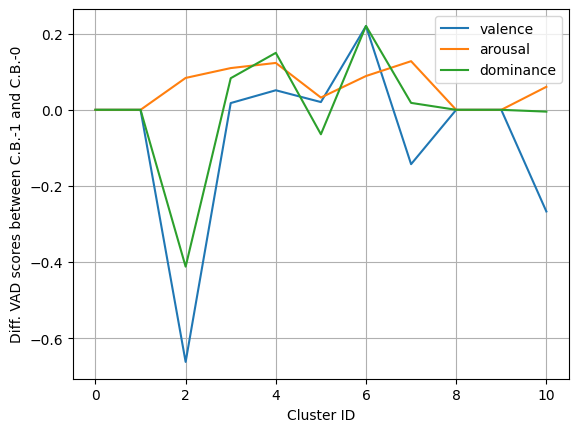

In [55]:
plt.figure(figsize=(10, 5))
(cb1_cluster_info[["valence", "arousal", "dominance"]] - cb0_cluster_info[["valence", "arousal", "dominance"]]).to_pandas().plot()
plt.xlabel("Cluster ID")
plt.ylabel("Diff. VAD scores between C.B.-1 and C.B.-0")
plt.grid()
plt.savefig(os.path.join(XAI1_PATH, f"{FILES_PREFIX}_nrc_vad_differences_HoTL_CB.pdf"), format="pdf", bbox_inches='tight')
plt.show()

In [46]:
cb0_cluster_info["closest_nrc_vad_cluster_id"].unique().to_list(), cb1_cluster_info["closest_nrc_vad_cluster_id"].unique().to_list()

([0, 1, 3, 4, 7, 8, 9, 13, 21, 26], [0, 2, 4, 5, 6, 9, 12, 13, 21])

Random contextual boundary

In [47]:
closest_nrc_vad_cluster_ids = []
valence_values = []
arousal_values = []
dominance_values = []
for row in random_cb0_cluster_info.iter_rows(named=True):
    centroid = row["centroid"]
    similarities = cosine_similarity([centroid], nrcvad_centroids)[0]
    closest_nrc_vad_cluster_id = int(np.argmax(similarities))
    closest_nrc_vad_cluster_ids.append(closest_nrc_vad_cluster_id)
    nrc_vad_row = nrcvad_cluster_info.filter(pl.col("cluster") == closest_nrc_vad_cluster_id).to_pandas().iloc[0]
    valence_values.append(nrc_vad_row["avg_valence"])
    arousal_values.append(nrc_vad_row["avg_arousal"])
    dominance_values.append(nrc_vad_row["avg_dominance"])

random_cb0_cluster_info = random_cb0_cluster_info.with_columns(
    pl.Series("closest_nrc_vad_cluster_id", closest_nrc_vad_cluster_ids),
    pl.Series("valence", valence_values, dtype=pl.Float64),
    pl.Series("arousal", arousal_values, dtype=pl.Float64),
    pl.Series("dominance", dominance_values, dtype=pl.Float64)
)

In [48]:
closest_nrc_vad_cluster_ids = []
valence_values = []
arousal_values = []
dominance_values = []
for row in random_cb1_cluster_info.iter_rows(named=True):
    centroid = row["centroid"]
    similarities = cosine_similarity([centroid], nrcvad_centroids)[0]
    closest_nrc_vad_cluster_id = int(np.argmax(similarities))
    closest_nrc_vad_cluster_ids.append(closest_nrc_vad_cluster_id)
    nrc_vad_row = nrcvad_cluster_info.filter(pl.col("cluster") == closest_nrc_vad_cluster_id).to_pandas().iloc[0]
    valence_values.append(nrc_vad_row["avg_valence"])
    arousal_values.append(nrc_vad_row["avg_arousal"])
    dominance_values.append(nrc_vad_row["avg_dominance"])

random_cb1_cluster_info = random_cb1_cluster_info.with_columns(
    pl.Series("closest_nrc_vad_cluster_id", closest_nrc_vad_cluster_ids),
    pl.Series("valence", valence_values, dtype=pl.Float64),
    pl.Series("arousal", arousal_values, dtype=pl.Float64),
    pl.Series("dominance", dominance_values, dtype=pl.Float64)
)

In [49]:
random_cb0_cluster_info[["valence", "arousal", "dominance"]].mean()

valence,arousal,dominance
f64,f64,f64
0.02316,0.019086,0.070752


In [50]:
random_cb1_cluster_info[["valence", "arousal", "dominance"]].mean()

valence,arousal,dominance
f64,f64,f64
0.04252,0.00944,0.070969


<Figure size 1000x500 with 0 Axes>

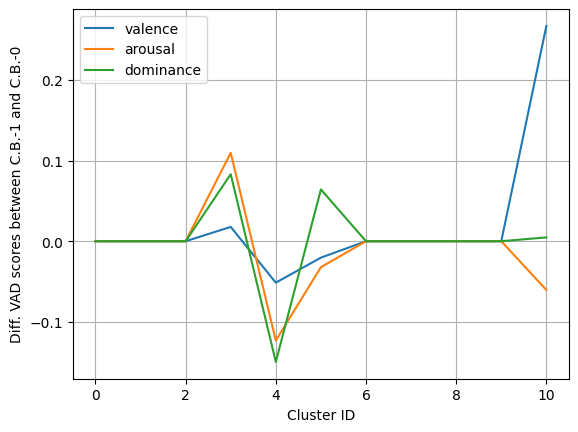

In [56]:
plt.figure(figsize=(10, 5))
(random_cb1_cluster_info[["valence", "arousal", "dominance"]] - random_cb0_cluster_info[["valence", "arousal", "dominance"]]).to_pandas().plot()
plt.xlabel("Cluster ID")
plt.ylabel("Diff. VAD scores between C.B.-1 and C.B.-0")
plt.grid()
plt.savefig(os.path.join(XAI1_PATH, f"{FILES_PREFIX}_nrc_vad_differences_random_CB.pdf"), format="pdf", bbox_inches='tight')
plt.show()

In [52]:
random_cb0_cluster_info["closest_nrc_vad_cluster_id"].unique().to_list(), random_cb1_cluster_info["closest_nrc_vad_cluster_id"].unique().to_list()

([0, 1, 4, 5, 8, 9, 12, 13, 21, 26], [0, 3, 4, 5, 6, 7, 8, 9, 13, 21, 26])

##### LLM-Generated Approach

In [53]:
assert False

AssertionError: 

In [ ]:
XAI2_PATH = os.path.join(XAI_OUTPUTS_PATH, "llm_generated")

In [ ]:
fpath = os.path.join(DATA_PATH, "prompt_template.txt")
if os.path.exists(fpath):
    with open(fpath, "r") as f:
        PROMPT_TEMPLATE = f.read()
    print(f"Loaded prompt template from {fpath}")
else:
    raise FileNotFoundError(f"Prompt template file not found at {fpath}")
del fpath

Loaded prompt template from /Users/tig1/Programming/TOPOL/data/prompt_template.txt


In [ ]:
def generate_narrative_comparison_prompt(text1, text2):
    prompt = PROMPT_TEMPLATE.replace("#####TEXT1#####", text1)
    prompt = prompt.replace("#####TEXT2#####", text2)
    return prompt

In [ ]:
# chat_completion_func, model_name = openai_chat_completion, "gpt-4o-mini-2024-07-18"
chat_completion_func, model_name = google_chat_completion, "gemini-2.0-flash"

text_generation_params = {
    "model": model_name,
    "temperature": 0.1,
    "top_p": 1.0,
    # "presence_penalty": 0.0,
    # "frequency_penalty": 0.0,
    "max_tokens": 1000000,
}

K = 5  # Number of top documents to retrieve for each cluster

HoTL proposed contextual boundary

In [ ]:
cb0_df = topol_model.df.filter(pl.col("label") == 0).clone()
top_k_docs = get_top_k_representative_docs(cb0_cluster_info, cb0_df, k=K)
cb0_cluster_info = cb0_cluster_info.join(top_k_docs, on="cluster", how="left")

In [ ]:
cb1_df = topol_model.df.filter(pl.col("label") == 1).clone()
top_k_docs = get_top_k_representative_docs(cb1_cluster_info, cb1_df, k=K)
cb1_cluster_info = cb1_cluster_info.join(top_k_docs, on="cluster", how="left")

In [ ]:
for cluster_id in tqdm(clusters, desc="Processing clusters"):
    cb0_row = cb0_cluster_info.filter(pl.col("cluster") == cluster_id).to_dicts()[0]
    cb1_row = cb1_cluster_info.filter(pl.col("cluster") == cluster_id).to_dicts()[0]

    # Generate the prompt for the LLM
    text1 = from_list_to_string(cb0_row["top_docs"])
    text2 = from_list_to_string(cb1_row["top_docs"])
    prompt = generate_narrative_comparison_prompt(text1, text2)
    response = chat_completion_func(prompt, **text_generation_params)

    # Parse the JSON response safely
    parsed_llm_out = safe_json_load(response)

    # Save to file
    fname = f"{FILES_PREFIX}_HoTL_cluster_{cluster_id}.json"
    fpath = os.path.join(XAI2_PATH, fname)
    with open(fpath, "w", encoding="utf-8") as f:
        json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

Processing clusters:   0%|          | 0/11 [00:00<?, ?it/s]

Response: ```json
[
  {
    "dimension_title": "Emphasis on Historical Analysis to Focus on Current Challenges",
    "text1_sentence_count": 2,
    "text2_sentence_count": 2,
    "confidence_label_text1": "Medium",
    "confidence_label_text2": "Medium",
    "confidence_score_text1": 3,
    "confidence_score_text2": 2,
    "text1_evidence_sentences": [
      "I do not intend this brief and necessarily incomplete review of events to illustrate how far we have come or to despair of how far we have to go.",
      "The risk-management approach has gained greater traction as a consequence of the step-up in globalization and the technological changes of DATE, which found us adjusting to events without the comfort of relevant history to guide us."
    ],
    "text2_evidence_sentences": [
      "That subject is the focus of my talk DATE.",
      "I will organize my remarks around the following two questions: First, what aspects of the existing literature in monetary economics have been particu

Random contextual boundary

In [ ]:
random_cb0_df = topol_model.df.filter(pl.col("random_label") == 0).clone()
top_k_docs = get_top_k_representative_docs(random_cb0_cluster_info, random_cb0_df, k=K)
random_cb0_cluster_info = random_cb0_cluster_info.join(top_k_docs, on="cluster", how="left")

In [ ]:
random_cb1_df = topol_model.df.filter(pl.col("random_label") == 1).clone()
top_k_docs = get_top_k_representative_docs(random_cb1_cluster_info, random_cb1_df, k=K)
random_cb1_cluster_info = random_cb1_cluster_info.join(top_k_docs, on="cluster", how="left")

In [ ]:
for cluster_id in tqdm(clusters, desc="Processing random clusters"):
    cb0_row = random_cb0_cluster_info.filter(pl.col("cluster") == cluster_id).to_dicts()[0]
    cb1_row = random_cb1_cluster_info.filter(pl.col("cluster") == cluster_id).to_dicts()[0]

    # Generate the prompt for the LLM
    text1 = from_list_to_string(cb0_row["top_docs"])
    text2 = from_list_to_string(cb1_row["top_docs"])
    prompt = generate_narrative_comparison_prompt(text1, text2)
    response = chat_completion_func(prompt, **text_generation_params)

    # Parse the JSON response safely
    parsed_llm_out = safe_json_load(response)

    # Save to file
    fname = f"{FILES_PREFIX}_random_cluster_{cluster_id}.json"
    fpath = os.path.join(XAI2_PATH, fname)
    with open(fpath, "w", encoding="utf-8") as f:
        json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

Processing random clusters:   0%|          | 0/11 [00:00<?, ?it/s]

Response: ```json
[
  {
    "dimension_title": "Emphasis on Historical Analysis to Forward-Looking Projections",
    "text1_sentence_count": 2,
    "text2_sentence_count": 2,
    "confidence_label_text1": "Medium",
    "confidence_label_text2": "Medium",
    "confidence_score_text1": 3,
    "confidence_score_text2": 4,
    "text1_evidence_sentences": [
      "As a consequence, the Federal Reserve was perceived by some as often accentuating, rather than damping, cycles in prices and activity.",
      "Importantly, however, the surge in prices that followed the removal of wage and price controls after World War II and again after the Korean War kept monetary policymakers wary of the threat of inflation."
    ],
    "text2_evidence_sentences": [
      "Effective communication not only about inflation but also about the possible path of the policy rate may be particularly important at the zero lower bound, when the scope to influence expectations through changes in the policy rate is obvio